<a href="https://colab.research.google.com/github/dhanushpachabhatla/My_LangChain_Playground/blob/main/Langchain_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langchain_community langchain langsmith langchain_google_genai --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [3]:
import os
from getpass import getpass

os.environ["LANGCHAIN_API_KEY"] = getpass("Enter LangSmith API Key: ")

# below should not be changed
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# you can change this as preferred
os.environ["LANGCHAIN_PROJECT"] = "pr-husky-bran-20"

Enter LangSmith API Key: ··········


In [4]:
import os
from getpass import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

os.environ['GOOGLE_API_KEY'] = getpass("Enter your GEMINI KEY")

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash',temperature= 0.2)

Enter your GEMINI KEY··········


## LCEL `RunnableParallel` and `RunnablePassthrough`

LCEL provides us with various `Runnable` classes that allow us to control the flow of data and execution order through our chains. Two of these are `RunnableParallel` and `RunnablePassthrough`.

* `RunnableParallel` — allows us to run multiple `Runnable` instances in parallel. Acting almost as a Y-fork in the chain.

* `RunnablePassthrough` — allows us to pass through a variable to the next `Runnable` without modification.

In [9]:
!pip install docarray --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 1.5 MB/s eta 0:00:00


In [10]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vecstore_a = DocArrayInMemorySearch.from_texts(
    [
        "half the info is here",
        "DeepSeek-V3 was released in December 2024"
    ],
    embedding=embedding
)
vecstore_b = DocArrayInMemorySearch.from_texts(
    [
        "the other half of the info is here",
        "the DeepSeek-V3 LLM is a mixture of experts model with 671B parameters"
    ],
    embedding=embedding
)

/usr/local/lib/python3.12/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


Here you can see the prompt does have three inputs, two for context and one for the question itself.

In [11]:
prompt_str = """Using the context provided, answer the user's question.
Context:
{context_a}
{context_b}
"""

In [12]:
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema.output_parser import StrOutputParser

output_parser = StrOutputParser()

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(prompt_str),
    HumanMessagePromptTemplate.from_template("{question}")
])

Here we are wrapping our vector stores as retrievers so they can be fitted into one big retrieval variable to be used by the prompt.

In [13]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

retriever_a = vecstore_a.as_retriever()
retriever_b = vecstore_b.as_retriever()

retrieval = RunnableParallel(
    {
        "context_a": retriever_a, "context_b": retriever_b, "question": RunnablePassthrough()
    }
)

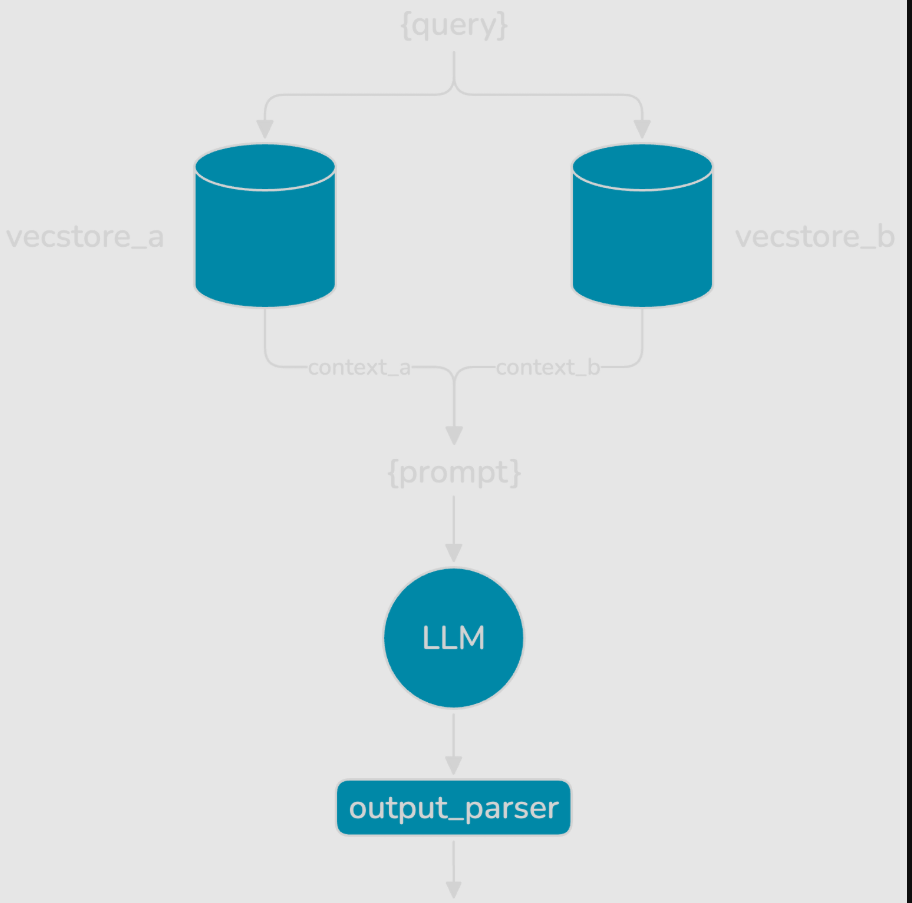

In [14]:
chain = retrieval | prompt | llm | output_parser

In [15]:
result = chain.invoke(
    "what architecture does the model DeepSeek released in december use?"
)
result

'The DeepSeek model released in December (DeepSeek-V3) uses a mixture of experts architecture.'